In [3]:
from openprompt.data_utils import InputExample
import torch
import pandas as pd
import os
import json, csv
from abc import ABC, abstractmethod
from collections import defaultdict, Counter
from typing import List, Dict, Callable

from openprompt.utils.logging import logger

from openprompt.data_utils.utils import InputExample
from openprompt.data_utils.data_processor import DataProcessor

import pandas as pd
import numpy as np
from tqdm import tqdm

from torchnlp.encoders import LabelEncoder

# first set up the dataprocessor for mortality prediction

In [2]:
# set dir to the mortality prediction data
data_dir = "../clinical-outcomes-data/mimic3-clinical-outcomes/mp/"

In [18]:
df = pd.read_csv(f"{data_dir}/train.csv")

In [7]:
len(df.id.unique())

33954

In [20]:
df

,id,text,hospital_expire_flag
0,107384,"CHIEF COMPLAINT: AMS, concern for toxic alcoho...",0
1,101061,CHIEF COMPLAINT: abdominal pain\n\nPRESENT ILL...,0
2,127180,CHIEF COMPLAINT: Bilateral Sub Dural Hematoma\...,0
3,168339,CHIEF COMPLAINT: Intracranial bleed\n\nPRESENT...,0
4,154044,CHIEF COMPLAINT: ischemic left foot\n\nPRESENT...,0
...,...,...,...
33949,122869,CHIEF COMPLAINT: Fever and neutropenia.\n\nPRE...,0
33950,145612,CHIEF COMPLAINT: Chest pain.\n\nPRESENT ILLNES...,0
33951,152495,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,0
33952,182652,"CHIEF COMPLAINT: Malaise, fever, chills, and L...",0


In [14]:
df.loc[0]['text']

'CHIEF COMPLAINT: AMS, concern for toxic alcohol ingestion\n\nPRESENT ILLNESS: Mr. [**Known lastname 27389**] is a 39 year old man with h/o EtOH and polysubstance abuse, seizure disorder, who was found to be unresponsive while visiting his partner in the ICU earlier today. . The patient was visiting his partner in the ICU earlier today. He was awake and conversant in the morning with no acute complaints. He was noted to be sleeping on the floor, but walked to the chair by himself when he was awakened. Later in the afternoon, the patient was noted to still be asleep in the chair. He was unarousable with verbal stimuli or sternal rub, so he was taken down to the ED. . In the ED, the patient was initially altered, but was otherwise hemodynamically stable. No urine incontinence or e/o toxidromes. Labs notable for EtOH 86, Osms 366, anion gap 16, lactate 3.8. Utox positive for barbs, but Stox and Utox otherwise negative. Given high serum osmolar gap (60), toxicology was consulted for concer

<AxesSubplot:>

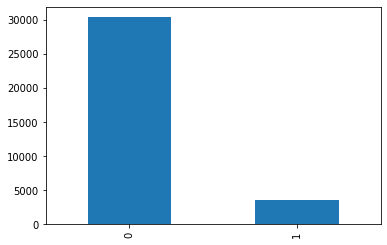

In [17]:
df.hospital_expire_flag.value_counts().plot(kind="bar")

In [23]:
# we actually want to convert the numerical labels to string 

df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})

In [24]:
df

,id,text,hospital_expire_flag,label
0,107384,"CHIEF COMPLAINT: AMS, concern for toxic alcoho...",0,alive
1,101061,CHIEF COMPLAINT: abdominal pain\n\nPRESENT ILL...,0,alive
2,127180,CHIEF COMPLAINT: Bilateral Sub Dural Hematoma\...,0,alive
3,168339,CHIEF COMPLAINT: Intracranial bleed\n\nPRESENT...,0,alive
4,154044,CHIEF COMPLAINT: ischemic left foot\n\nPRESENT...,0,alive
...,...,...,...,...
33949,122869,CHIEF COMPLAINT: Fever and neutropenia.\n\nPRE...,0,alive
33950,145612,CHIEF COMPLAINT: Chest pain.\n\nPRESENT ILLNES...,0,alive
33951,152495,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,0,alive
33952,182652,"CHIEF COMPLAINT: Malaise, fever, chills, and L...",0,alive


In [52]:
class Mimic_Mortality_Processor(DataProcessor):


    '''
    Function to convert mimic mortality prediction dataset from the clinical outcomes paper: https://aclanthology.org/2021.eacl-main.75/
    
    to a open prompt ready dataset. 
    
    We also instantiate a LabelEncoder() class which is fitted to the given dataset. Fortunately it appears
    to create the same mapping for each set, given each set contains all classes.    
    
    '''
    # TODO Test needed
    def __init__(self):
        super().__init__()        

    def get_examples(self, data_dir, mode = "train", label_encoder = None,
                     generate_class_labels = False, class_labels_save_dir = "./scripts/mimic_mortality/"):

        path = f"{data_dir}/{mode}.csv"
        print(f"loading {mode} data")
        print(f"data path provided was: {path}")
        examples = []
        df = pd.read_csv(path)

        # map the binary classification label to a new string class label
        df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})
        
        # need to either initializer and fit the label encoder if not provided
        if label_encoder is None:
            self.label_encoder = LabelEncoder(np.unique(df["label"]).tolist())
        else: 
            print("we were given a label encoder")
            self.label_encoder = label_encoder

        
        for idx, row in tqdm(df.iterrows()):
#             print(row)
            body, label = row['text'],row['label']
            label = self.label_encoder.encode(label)
#             print(f"body : {body}")
#             print(f"label: {label}")
#             print(f"labels original: {self.label_encoder.index_to_token[label]}")
            
            text_a = body.replace('\\', ' ')

            example = InputExample(
                guid=str(idx), text_a=text_a, label=int(label))
            examples.append(example)
            
        logger.info(f"Returning {len(examples)} samples!") 

#         now we want to return a list of the non-encoded labels based on the fitted label encoder
        if generate_class_labels:
        
            if not os.path.exists(class_labels_save_dir):
                os.makedirs(class_labels_save_dir)
            logger.info(f"Saving class labels to: {class_labels_save_dir}")
            class_labels = self.generate_class_labels()
            # write these to files as the classes for prompt learning pipeline           

            textfile = open(f"{class_labels_save_dir}/labels.txt", "w")

            for element in class_labels[:-1]:

                textfile.write(element + "\n")
            # now write the last item to the file
            textfile.write(class_labels[-1])
            textfile.close() 

        return examples

    def generate_class_labels(self):
        # now we want to return a list of the non-encoded labels based on the fitted label encoder
        try:
            return list(self.label_encoder.tokens.keys())
        except:
            print("No class labels as haven't fitted any data yet. Run get_examples first!")
            raise NotImplementedError

    
    def load_class_labels(self, file_path = "./scripts/mimic_mortality/labels.txt"):
        # function to load pre-generated class labels
        # returns list of class labels

        text_file = open(f"{file_path}", "r")

        class_labels = text_file.read().split("\n")

        return class_labels

In [53]:
# get different splits
dataset = {}
dataset['train'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}", mode = "train", generate_class_labels = True)
dataset['valid'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}",mode = "valid" )


loading train data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//train.csv


33954it [00:02, 12930.69it/s]


loading valid data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//valid.csv


4908it [00:00, 14706.11it/s]


In [30]:
dataset['train']

[{
   "guid": "0",
   "label": 0,
   "meta": {},
   "text_a": "CHIEF COMPLAINT: AMS, concern for toxic alcohol ingestion\n\nPRESENT ILLNESS: Mr. [**Known lastname 27389**] is a 39 year old man with h/o EtOH and polysubstance abuse, seizure disorder, who was found to be unresponsive while visiting his partner in the ICU earlier today. . The patient was visiting his partner in the ICU earlier today. He was awake and conversant in the morning with no acute complaints. He was noted to be sleeping on the floor, but walked to the chair by himself when he was awakened. Later in the afternoon, the patient was noted to still be asleep in the chair. He was unarousable with verbal stimuli or sternal rub, so he was taken down to the ED. . In the ED, the patient was initially altered, but was otherwise hemodynamically stable. No urine incontinence or e/o toxidromes. Labs notable for EtOH 86, Osms 366, anion gap 16, lactate 3.8. Utox positive for barbs, but Stox and Utox otherwise negative. Given hi

In [54]:
class_labels = Mimic_Mortality_Processor().load_class_labels()

In [55]:
class_labels

['alive', 'deceased']

In [56]:
le = LabelEncoder(class_labels, reserved_labels = [])

In [57]:
le.tokens.keys()

dict_keys(['alive', 'deceased'])